# Building Circuit Models from Layout Files

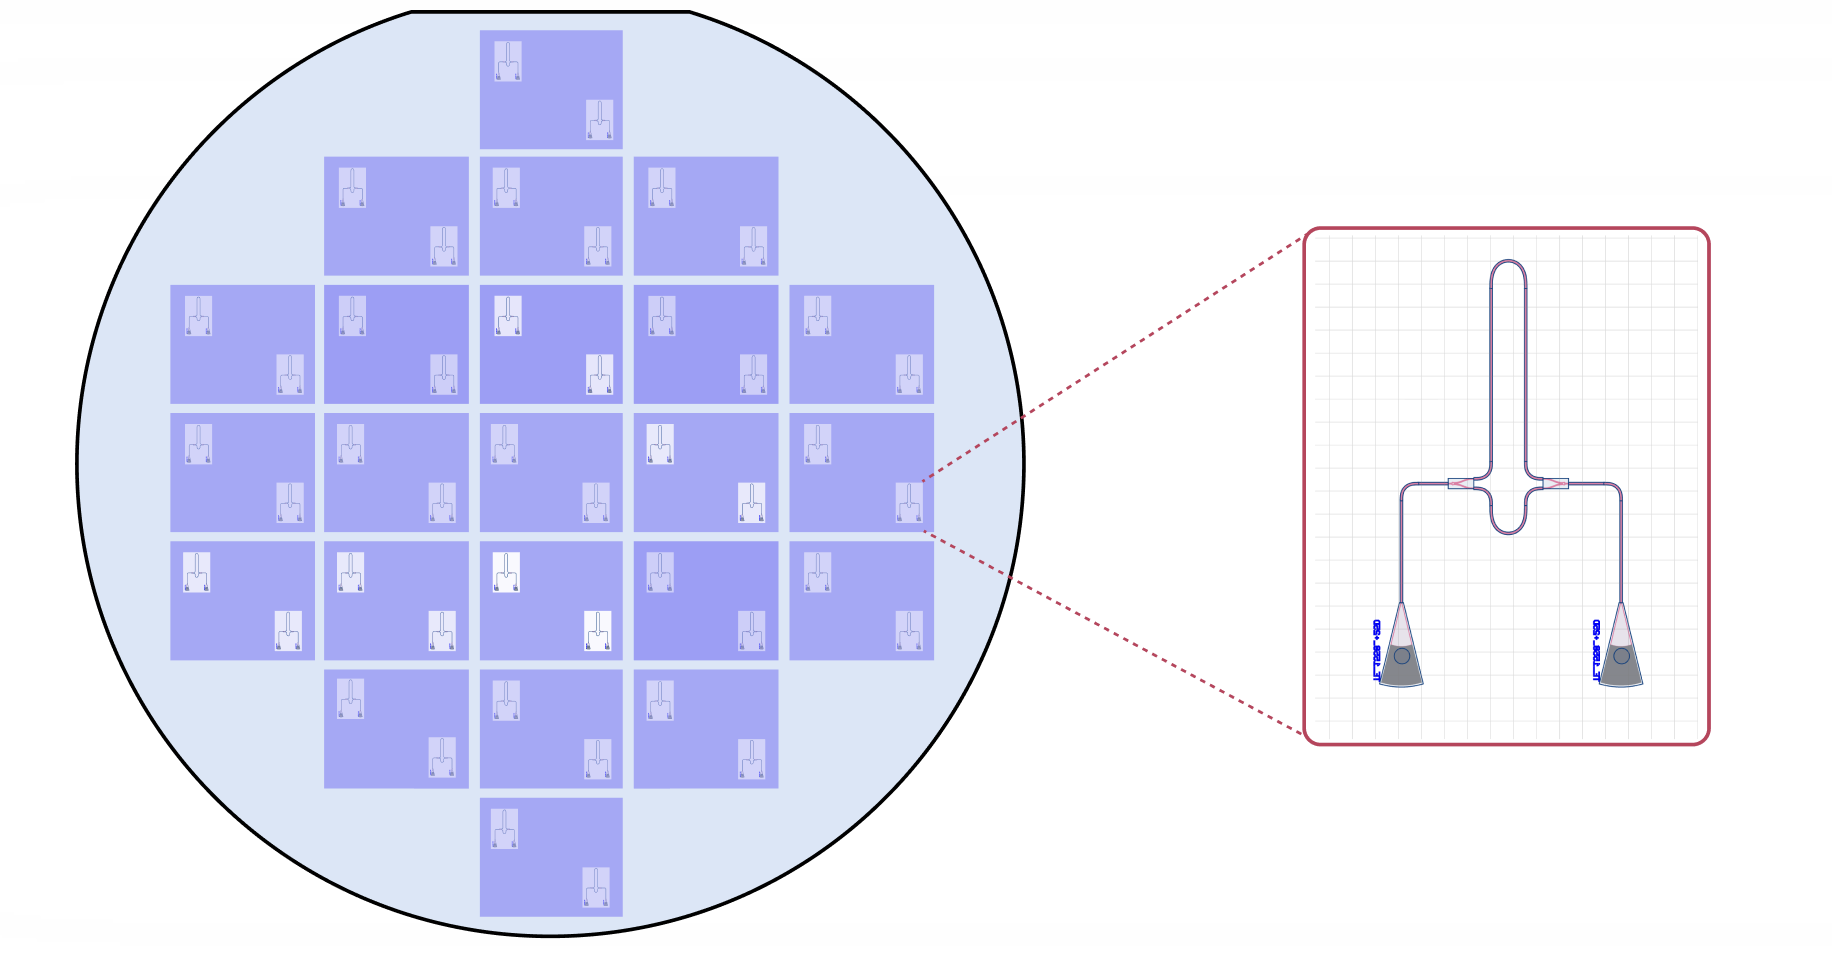

In this notebook, we will see how to load GDSII layouts and run both component- and circuit-level simulations.
This allows designers to import GDSII files generated from other software tools and evaluate their optical responses.

With a simulation model, we can see how fabrication variations (such as sidewall angles, layer thicknesses, refractive indices, etc.) impact circuit-level performance.

In this demo, we'll learn how to:
- Import hierarchical designs from GDSII files;
- Detect ports and assign component models;
- Create circuit models; and
- Update the fabrication parameters to see impact on the circuit level S matrix.

We begin by first loading libraries for PhotonForge, Tidy3D and the open-source [SiEPIC OpenEBL PDK](https://siepic.ca/openebl/), as well as and others we will require.
To install the SiEPIC PDK please follow [these steps](../index.rst#optional-pdk-installation).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
import photonforge.live_viewer as live_viewer
import siepic_forge as siepic_pdk
import tidy3d as td

Assign open-source Siepic PDK as our default technolgy and set some configurations.

In [2]:
tech = siepic_pdk.ebeam()
pf.config.default_technology = tech

pf.config.default_mesh_refinement = 12  # Decreased accuracy only to run the example

pf.config.svg_labels = False

Let's begin by loading the GDSII file [external_mzi.gds](external_mzi.gds) using the [load_layout](../_autosummary/photonforge.load_layout.rst) function.
This file was created using an open-source PDK software package for fabrication in SiEPIC foundry, meaning the layer-stacks and PDK components adhere to the specifications provided by the foundry.

We can inspect the data, which is loaded as a dictionary of components (GDSII cells) indexed by name.

In [3]:
gds_data = pf.load_layout("external_mzi.gds")

for component_name in gds_data.keys():
    print(component_name)

$$$CONTEXT_INFO$$$
mzi_DL200
straight_L100_N2_CSstrip
mzi_with_gratings_DL200
delayline_DL0
delayline_DL200
bend_euler_CSstrip_A180
bend_euler_CSstrip
straight_L20p358_N2_CSx_23d87c0c
straight_L58p878_N2_CSx_33fc2739
straight_L17p043_N2_CSx_3c6d3aa8
ebeam_y_1550
gc_te1550_broadband


We are interested in creating a simulation model for the unbalanced MZI with grating couplers.

If we ignore the `"$$$CONTEXT_INFO$$$"` cell, which includes all others, we can look for the top-level component with the [find_top_level](../_autosummary/photonforge.find_top_level.rst) helper function:

In [4]:
top_level = pf.find_top_level(v for k, v in gds_data.items() if k[0] != "$")

for component in top_level:
    print(component.name)

mzi_with_gratings_DL200


In [5]:
mzi_circuit = top_level[0]
mzi_circuit

In [6]:
type(mzi_circuit)

photonforge.Component

If we want to inspect the device geometry carefully, we can use the browser-based [layout viewer](../_autosummary/photonforge.live_viewer.LiveViewer.rst).

In [7]:
from photonforge.live_viewer import LiveViewer

viewer = LiveViewer()

Starting live viewer at http://localhost:5001


In [8]:
viewer.display(mzi_circuit)

We can also visualize all hierarchical nature of how this GDSII file was created.

Feel free to set `interactive = True` to visualize the components in this heirarchy.
We see several independent components such as `ebeam_y_1550`, `gc_te1550_broadband`, and `bend_euler_CSstrip` that make up the circuit.

In [9]:
mzi_circuit.tree_view(interactive=False)

mzi_with_gratings_DL200
├─ mzi_DL200
│  ├─ ebeam_y_1550
│  ├─ delayline_DL200
│  │  ├─ bend_euler_CSstrip
│  │  ├─ straight_L100_N2_CSstrip
│  │  └─ bend_euler_CSstrip_A180
│  └─ delayline_DL0
│     ├─ bend_euler_CSstrip
│     └─ bend_euler_CSstrip_A180
├─ gc_te1550_broadband
├─ bend_euler_CSstrip
├─ straight_L17p043_N2_CSx_3c6d3aa8
├─ straight_L58p878_N2_CSx_33fc2739
└─ straight_L20p358_N2_CSx_23d87c0c

GDSII files contains only layout information.
In order to build a circuit model, we will identify all components with no dependencies (leaves in the dependency tree) and specify their [ports](../guides/Ports.ipynb) and [models](../models.rst) to calculate their individual S parameters.
PhotonForge will then use the physical connections between them to build the circuit model.

Let us start by looking at all the [dependencies](../_autosummary/photonforge.Component.rst#photonforge.Component.dependencies) of the `mzi_circuit` component.
To identify independent components we need to find the ones that have no further [references](../_autosummary/photonforge.Reference.rst) (references in PhotonForge are like instances of components).

In [10]:
# Gather all components with no dependencies (no references to other components)
independent_components = [
    c for c in mzi_circuit.dependencies() if len(c.references) == 0
]

# Sort the list by name
independent_components.sort(key=lambda c: c.name)

print("Independent components:")
for i, component in enumerate(independent_components):
    print(f"- [{i}] {component.name}")

Independent components:
- [0] bend_euler_CSstrip
- [1] bend_euler_CSstrip_A180
- [2] ebeam_y_1550
- [3] gc_te1550_broadband
- [4] straight_L100_N2_CSstrip
- [5] straight_L17p043_N2_CSx_3c6d3aa8
- [6] straight_L20p358_N2_CSx_23d87c0c
- [7] straight_L58p878_N2_CSx_33fc2739


## Sub-component setup

Now depending on the type of the component we are looking at we might have to add different ports and models.
For example, for `gc_te1550_broadband`, we want to add a [data model](../guides/Data_Model.ipynb) and an additional [Gaussian port](../_autosummary/photonforge.GaussianPort.rst).
For `ebeam_y_1550` we might want to run [FDTD simulations](../guides/Tidy3D_Model.ipynb).
For straight waveguides (or bends with insignificant loss) we might want a semi-analytical [waveguide model](../_autosummary/photonforge.WaveguideModel.rst).

We will add ports and models to the independent components one by one to show a few details in the process.
Later, this process can be completely automated, if needed, based on the expected GDSII contents.

### Component 0

In [11]:
component = independent_components[0]
viewer.display(component)

By inspecting the component in the live viewer, we see that the routes correspond to a 500 nm wide silicon strip waveguide.
The PDK provides the default port specification "TE_1550_500" that matches this profile, so we will be using that to find ports.
Note that we can easily [inspect the ports](../guides/Ports.ipynb#Inspecting-Ports) of any technology.

In [12]:
port_spec = tech.ports["TE_1550_500"]
wg_width, _ = port_spec.path_profile_for((1, 0))
wg_width

0.5

In [13]:
# Automatically detect ports
edge_ports = component.detect_ports([port_spec], on_boundary="xy")
for port in edge_ports:
    print(port)

Port at (0, 0) at 0 deg with spec "Strip TE 1550 nm, w=500 nm"
Port at (10, 10) at 270 deg with spec "Strip TE 1550 nm, w=500 nm"


In [14]:
# Add ports
component.add_port(edge_ports)
viewer.display(component)

For 2-port routes where we don't need to include bend losses, the [waveguide model](../_autosummary/photonforge.WaveguideModel.rst) can be used to efficiently compute the S parameters from a single mode-solving calculation and the route length.
Otherwise, full FDTD models can always be used to completely characterize the geometry.

In [15]:
# Use the area of the waveguide polygon in the layer (1,0) and waveguide width to estimate the route length
area = sum(s.area() for s in component.structures[1, 0])
length = area / wg_width
component.add_model(pf.WaveguideModel(length=length), "Waveguide")
print(f"The length of this path is {length:.3f} μm")

The length of this path is 16.637 μm


### Component 1

The second component is very similar to the first we processed.

In [16]:
component = independent_components[1]
viewer.display(component)

In [17]:
# We can limit the search for port to a single boundary
edge_ports = component.detect_ports([port_spec], on_boundary="-x")
for port in edge_ports:
    print(port)

Port at (0, 0) at 0 deg with spec "Strip TE 1550 nm, w=500 nm"
Port at (0, 20) at 0 deg with spec "Strip TE 1550 nm, w=500 nm"


In [18]:
# Add ports
component.add_port(edge_ports)

# Add model
length = sum(s.area() for s in component.structures[1, 0]) / wg_width
component.add_model(pf.WaveguideModel(length=length), "Waveguide")
print(f"The length of this route is {length:.3f} μm")

viewer.display(component)

The length of this route is 42.817 μm


### Component 2

In [19]:
component = independent_components[2]
viewer.display(component)

Because the port on the -x side has a rectangular box around the actual port edge, looking for ports at the exact boundaries will not work, so we add a 200 nm margin to the search:

In [20]:
edge_ports = component.detect_ports([port_spec], on_boundary="x", boundary_margin=0.2)
for port in edge_ports:
    print(port)

Port at (-7.4, 0) at 0 deg with spec "Strip TE 1550 nm, w=500 nm"
Port at (7.4, -2.75) at 180 deg with spec "Strip TE 1550 nm, w=500 nm"
Port at (7.4, 2.75) at 180 deg with spec "Strip TE 1550 nm, w=500 nm"


In [21]:
# Add ports
component.add_port(edge_ports)

# Add Tidy3D model
component.add_model(pf.Tidy3DModel(port_symmetries=[("P0", "P2", "P1")]), "Tidy3D")

viewer.display(component)

### Component 3

In [22]:
component = independent_components[3]
viewer.display(component)

In [23]:
edge_ports = component.detect_ports([port_spec], on_boundary="x", boundary_margin=0.2)
component.add_port(edge_ports)
viewer.display(component)

The free-space port for the grating coupler is best modeled by a [Gaussian port](../_autosummary/photonforge.GaussianPort.rst), which can be used to accurately compute the S matrix based on an Tidy3D model.
Alternatively, if we have the data available, a data model can be used as in the [foundry PIC design example](Foundry_PIC_Design.ipynb#Adding-GCs-for-layout).

If we are not really interested in adding the effects of the grating coupler, a simpler alternative is to add another waveguide port (even if the geometry does not match it) and an analytical [2-port model](../_autosummary/photonforge.TwoPortModel.rst), as we do below.

In [24]:
# Dummy waveguide port
component.add_port(
    pf.Port(component["P0"].center + (30, 0), input_direction=180, spec=port_spec)
)

component.add_model(pf.TwoPortModel(), "Analytical")

viewer.display(component)

### Components 4 – 7

For the rest of the components which are simply straight waveguides, we add semi-analytical models again.
For straight waveguides, PhotonForge automatically calculates the length so we do not need to explicitly specific length argument when specifying `WaveguideModel`.

In [25]:
for component in independent_components[4:]:
    edge_ports = component.detect_ports([port_spec], on_boundary="x")
    component.add_port(edge_ports)
    component.add_model(pf.WaveguideModel(), "WaveguideModel")

In [26]:
viewer.display(independent_components[7])

Now let's look at the overall circuit.
We can enable reference port drawing to see that all connections are accounted for.

In [27]:
pf.config.svg_reference_ports = True

viewer.display(mzi_circuit)

We can see that, once ports are defined for individual components, PhotonForge detects the connections, which we can see by inspecting the netlist.
Now, we just need to define ports and model for the final circuit.

In [28]:
mzi_circuit.get_netlist()["connections"]

[((6, 'P1', 1), (7, 'P0', 1)),
 ((6, 'P0', 1), (8, 'P0', 1)),
 ((3, 'P1', 1), (4, 'P0', 1)),
 ((3, 'P0', 1), (5, 'P0', 1)),
 ((2, 'P0', 1), (8, 'P1', 1)),
 ((1, 'P0', 1), (5, 'P1', 1))]

### Circuit ports and models

In our case we want the ports for the grating coupler references to be the final ports.
Because the component has a hierarchical structure, we also need to add reference ports and models to each sub-component like `mzi_DL200`, `delayline_DL200` and so on.
The [add_reference_ports](../_autosummary/photonforge.Component.rst#photonforge.Component.add_reference_ports) function allows us to recursively add ports and [circuit models](../guides/Circuit_Model.ipynb) to these hierarchical sub-components.

In [29]:
mzi_circuit.add_reference_ports(include_dependencies=True, add_model=pf.CircuitModel())

pf.config.svg_reference_ports = False

viewer.display(mzi_circuit)

## S-matrix computation

Now that ports and models are defined, all we need to do is to call [s_matrix](../_autosummary/photonforge.Component.rst#photonforge.Component.s_matrix) on the top-level component.

In [30]:
wavelengths = np.linspace(1.545, 1.55, 101)

s_matrix_initial = mzi_circuit.s_matrix(pf.C_0 / wavelengths)

Loading cached simulation from .tidy3d/pf_cache/W34/fdtd_info-NAO3DBWFMPFZOXZFRZAKXTKIOY736UHI5UTOEK4RV6YUXY3TCJQA.json.
Loading cached simulation from .tidy3d/pf_cache/W34/fdtd_info-OMVDWXZEIRYTMCZCWKZKQUPHUV6VJHYZGHHW5GSOBVDYISGMA63Q.json.
Loading cached simulation from .tidy3d/pf_cache/QD2/ms_info-EYLMZRG5ATYQQGCCUC66RIVJGH6CKDA633PGYUBJYRJRDOOYDJAA.json.
Loading cached simulation from .tidy3d/pf_cache/AVD/ms_info-QX2UX4AJ42YHRUBS67LXXMPLASHWTO5N66RE5KPK7UH7OUC4B4ZQ.json.


Loading cached simulation from .tidy3d/pf_cache/RJW/ms_info-RCYBBZLPRY4NJ52NOMFPJC3VZNLSYTTGWXQWCRSJCTZIIOOL7I7A.json.
Loading cached simulation from .tidy3d/pf_cache/YPZ/ms_info-XAXJK4JNVERXQC4E6MKVFAPHG272SXMEFPTMR2TDJMXEDNNKTTKQ.json.
Loading cached simulation from .tidy3d/pf_cache/2MR/ms_info-QYWW4RCMWWZOOAGPIKFV4VVCFRRPIMNJ7WZUEZWGROA64O57Q4YQ.json.


Loading cached simulation from .tidy3d/pf_cache/2PF/ms_info-M75CB4IBYHDOMRHNCCY2FG3HJ2BZUFEMJETPOI7RWUFYLJKKL5XA.json.
Loading cached simulation from .tidy3d/pf_cache/EOE/ms_info-677FFKYZYFDPYWOKFNTY7F7KXKEC4HV4SN5UU2NQ6NH52R6H4Y5Q.json.


Loading cached simulation from .tidy3d/pf_cache/L72/fdtd_info-6AZ5HS4HBM2ZURQYS25NQYGAV26URDY5BVQLGFR2FVI7YL2DRMBQ.json.
Loading cached simulation from .tidy3d/pf_cache/L72/fdtd_info-GCOXUGVIVEJQZCYIEKSDJTK4O4PWSAVXA5MERSNNAR5OTJOL3LNA.json.


Progress: 100% 


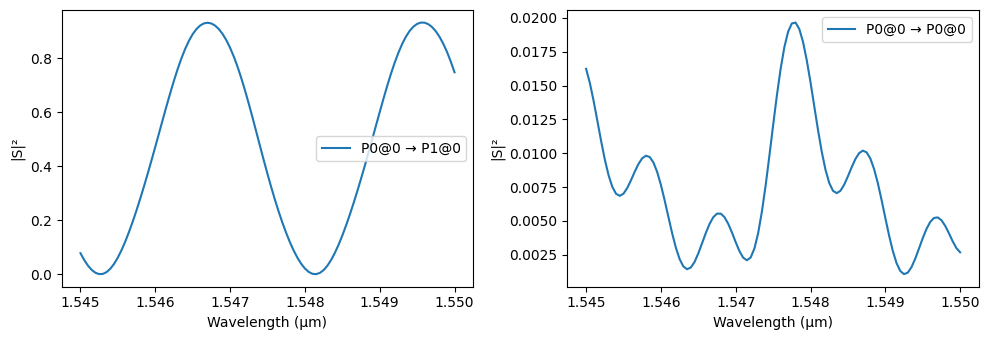

In [31]:
_ = pf.plot_s_matrix(s_matrix_initial, input_ports=["P0"])

Let us calculate the FSR for the MZI based on the group index of the routing waveguide and compare to the value we can extract from the S parameters.
$$
\text{FSR} = \frac{\lambda^2}{n_g \Delta L}
$$

In [32]:
lda = 1.55

mode_solver = pf.port_modes(
    port_spec, frequencies=[pf.C_0 / lda], mesh_refinement=40, group_index=True
)
mode_solver.data.to_dataframe()

Loading cached simulation from .tidy3d/pf_cache/EBV/ms_info-PNP5UWEKCV6P3NM53B65IZHZCMHPXJT7GNZAZ232WELRPVQEKSKA.json.


Progress: 100%


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  2.442851    0.0          0.983471   

                         wg TE fraction  wg TM fraction  mode area  \
f            mode_index                                              
1.934145e+14 0                 0.763901        0.817692   0.191378   

                         group index  dispersion (ps/(nm km))  
f            mode_index                                        
1.934145e+14 0              4.185971               499.924087

In [33]:
dl = 200
ng = mode_solver.data.n_group.isel(mode_index=0, f=0).item()
fsr = lda**2 / (ng * dl)

print(
    f"Estimated FSR from group index calculation using mode solver is {fsr * 1e3:.2f} nm"
)

Estimated FSR from group index calculation using mode solver is 2.87 nm


We can get the FSR from the S parameters using `scipy` to find the transmission dips:

FSR from S-matrix is: 2.90 nm


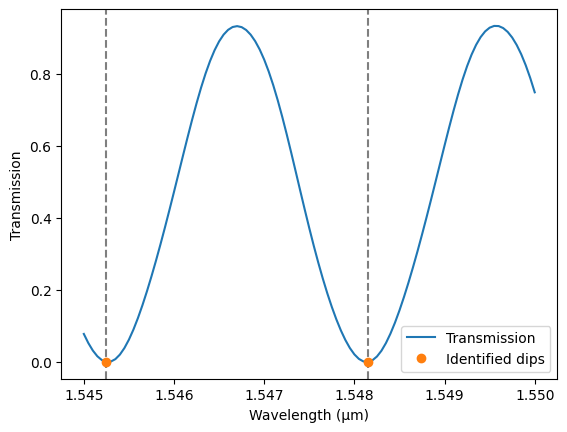

In [34]:
from scipy.signal import find_peaks

# We can calculate FSR from the data
transmission = np.abs(s_matrix_initial["P0@0", "P1@0"]) ** 2

# Find dips by inverting the signal: adjust prominence and distance as needed
dips, properties = find_peaks(-transmission, prominence=0.01, distance=5)

# Plot original data
_, ax = plt.subplots(1, 1)
ax.plot(wavelengths, transmission, label="Transmission")

# Plot identified dips
for dip in dips:
    ax.axvline(wavelengths[dip], ls="--", color="tab:gray")

ax.plot(wavelengths[dips], transmission[dips], "o", label="Identified dips")

ax.set(xlabel="Wavelength (µm)", ylabel="Transmission")
ax.legend()

fsr_s = wavelengths[dips[1]] - wavelengths[dips[0]]
print(f"FSR from S-matrix is: {fsr_s * 1e3:.2f} nm")

## Technology variations

During fabrication a number of parameters like the thickness of silicon, sidewall angle, and even material parameters may vary across the wafer.
In order to study the impact of these parameters on the performance of the circuit, we can simply [update](../_autosummary/photonforge.Technology.rst#photonforge.Technology.update) the technology and re-run S-matrix computation. 

In [35]:
# Since the technology itself is parametric we can inspect what parameters we can update
for k, v in tech.parametric_kwargs.items():
    s = str(v)
    if len(s) > 16:
        s = f"{v.__class__.__name__}(…)"
    print(f"- {k} = {s}")

- si_thickness = 0.22
- si_slab_thickness = 0.09
- sin_thickness = 0.4
- si_mask_dilation = 0.0
- si_slab_mask_dilation = 0.0
- sin_mask_dilation = 0.0
- sidewall_angle = 0.0
- metal_si_separation = 2.2
- router_thickness = 0.6
- heater_thickness = 0.2
- top_oxide_thickness = 0.3
- bottom_oxide_thickness = 3.017
- include_top_opening = False
- include_substrate = False
- sio2 = dict(…)
- si = dict(…)
- sin = dict(…)
- router_metal = dict(…)
- heater_metal = dict(…)
- opening = Medium(…)


Now, let's update the silicon thickness and see the impact of that on our s-matrix.

In [36]:
_ = tech.update(si_thickness=0.215)

s_matrix_thin = mzi_circuit.s_matrix(pf.C_0 / wavelengths)

# It's a good idea to reset the value to the original, in case we forget later
_ = tech.update(si_thickness=0.2)

Loading cached simulation from .tidy3d/pf_cache/W34/fdtd_info-M34UMJZWMIKP5GME36QCLXMOFGV744T6JCDRTTF6VBNLZNHG6MAQ.json.


Loading cached simulation from .tidy3d/pf_cache/W34/fdtd_info-ZQTCO22CF4NQYGEGUH5R6AJIHOMZVA4GVHVFH24QGBDR7T45Y62A.json.
Loading cached simulation from .tidy3d/pf_cache/XL6/ms_info-2TG6MEBP6EBX6FEUPRBFFFLAMYVZK7YVWTWYV7SSPA2Q5EHCARGQ.json.


Loading cached simulation from .tidy3d/pf_cache/TBQ/ms_info-IBQRCAHTBGBRIFEU7X7DUKFZL4GAI32F3XXCJA2OUTUBSXIPLHHQ.json.
Loading cached simulation from .tidy3d/pf_cache/57S/ms_info-PLWTD75I4CTLV6UHHPAHKCN6RVFSWI3C2JB2BFCGA6EUPFAUT27Q.json.


Loading cached simulation from .tidy3d/pf_cache/7MF/ms_info-BLAZQI7QAQ3SUGZJ453NDD5MEEUDMLL5Q7OGYRUUNN4IGY4DBIAA.json.
Loading cached simulation from .tidy3d/pf_cache/DGP/ms_info-BRCHDZVMCOXBAK7AFJBNIWO5GR5TABRHHEZQJGX2OGVX44EMXYCQ.json.


Loading cached simulation from .tidy3d/pf_cache/ESZ/ms_info-GFD6PVAP2KL5KRLFSTKH5YDSUGM35EU2HMVMEQ6Q2JN222UJ3MFA.json.
Loading cached simulation from .tidy3d/pf_cache/ZKF/ms_info-32TKE4INWBCYBXEVQ2EXZGNZCG3ZVGYKRQ2U3UYHRXSQ35DJ3K7Q.json.


Loading cached simulation from .tidy3d/pf_cache/L72/fdtd_info-3WOVAXTN2PKXXDI6LJPEOJA6ARRNKUVZNEZWBBWRFK2YOE6J5G6Q.json.
Loading cached simulation from .tidy3d/pf_cache/L72/fdtd_info-SUSKWJGO6HM5QTF5BMVZB7JC5NVYOYDJBJVYIEREI6TTJYOVLLGQ.json.


Progress: 100% 


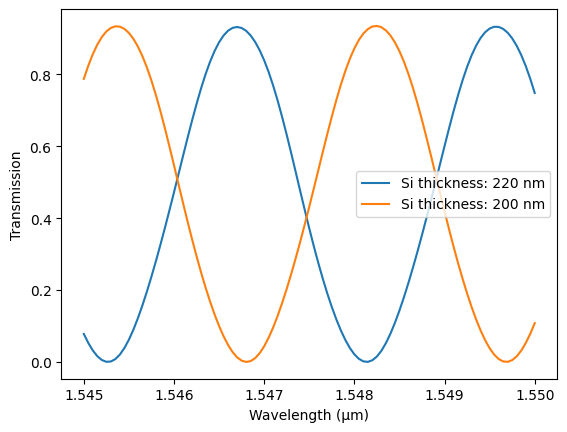

In [37]:
transmission2 = np.abs(s_matrix_thin["P0@0", "P1@0"]) ** 2

_, ax = plt.subplots(1, 1)
ax.plot(wavelengths, transmission, label="Si thickness: 220 nm")
ax.plot(wavelengths, transmission2, label="Si thickness: 200 nm")

ax.set(xlabel="Wavelength (µm)", ylabel="Transmission")
_ = ax.legend()

As expected, changing silicon waveguide thinkness across the wafer even by 5 nm will dramatically impact the unbalanced MZM response.
One can also perform [Monte-Carlo](../_autosummary/photonforge.monte_carlo.s_matrix.rst)  simulations to look at how fabrication variations impact overall circuit performance.

## Removing a delay arm

Now, let's see what happens to the circuit performance if we delete one of the delay arms.
We can use the tree view to get the reference numbers within each component:

In [38]:
mzi_circuit.tree_view(by_reference=True)

mzi_with_gratings_DL200
├─[0] mzi_DL200
│     ├─[0] ebeam_y_1550
│     ├─[1] delayline_DL200
│     │     ├─[0] bend_euler_CSstrip
│     │     ├─[1] straight_L100_N2_CSstrip
│     │     ├─[2] bend_euler_CSstrip_A180
│     │     ├─[3] straight_L100_N2_CSstrip
│     │     └─[4] bend_euler_CSstrip
│     ├─[2] delayline_DL0
│     │     ├─[0] bend_euler_CSstrip
│     │     ├─[1] bend_euler_CSstrip_A180
│     │     └─[2] bend_euler_CSstrip
│     └─[3] ebeam_y_1550
├─[1] gc_te1550_broadband
├─[2] gc_te1550_broadband
├─[3] bend_euler_CSstrip
├─[4] straight_L17p043_N2_CSx_3c6d3aa8
├─[5] straight_L58p878_N2_CSx_33fc2739
├─[6] bend_euler_CSstrip
├─[7] straight_L20p358_N2_CSx_23d87c0c
└─[8] straight_L58p878_N2_CSx_33fc2739

In [39]:
# from the tree view, remove delayline_DL0 from mzi_DL200
mzi_circuit.references[0].component.remove(
    mzi_circuit.references[0].component.references[2]
)

In [40]:
viewer.display(mzi_circuit)

In [41]:
s_matrix_new = mzi_circuit.s_matrix(pf.C_0 / wavelengths)

Loading cached simulation from .tidy3d/pf_cache/W34/fdtd_info-4VCTQXYPK2F7UGZI5OYI6X77QDRDWWUO7PZYCQVEXXED5U4JSE7A.json.
Loading cached simulation from .tidy3d/pf_cache/W34/fdtd_info-VN4LO4WJXJG237XTNXA3JWXS7X6GCBZSMGRHAL4CAPX2ULGB445A.json.


Loading cached simulation from .tidy3d/pf_cache/5IO/ms_info-AES2TXJB4Y2BJHAFPTESMCD35I7PKVE2RGQXQVMTDRK7PLWX4RCQ.json.
Loading cached simulation from .tidy3d/pf_cache/6BD/ms_info-YLPORW6OYSBGMD5LSYSNMVESGXK6QZJTZBC3R6B7FEUHYQ7C5DBA.json.
Loading cached simulation from .tidy3d/pf_cache/PIF/ms_info-EVPBYM7KDBIHNZ4K7HA3RUL2O2TZGYBOVXMP4P2ZYILKW6NA7WQQ.json.
Loading cached simulation from .tidy3d/pf_cache/FBN/ms_info-5DZRL7ZWJQX372JDBXA3R7JTU54OQYMDJXIZZVPXHLQCVVKGUDJQ.json.


Loading cached simulation from .tidy3d/pf_cache/PMT/ms_info-6PHWCL4DUUYCSIP3KPNVU5QBFY5ZXQPD7VEP6SZPZVQRESXP7XKA.json.


Loading cached simulation from .tidy3d/pf_cache/L72/fdtd_info-UVQZXXN7YCFQNEE4TIBNJXATEHNK4CQ6O4LQLMCILAPBBTNKVSFA.json.


Loading cached simulation from .tidy3d/pf_cache/L72/fdtd_info-XPRSETS64CNVRFYCSDIAXC6PZB6YKO3BQOE7DLBQOKBJJT23KM4A.json.


Loading cached simulation from .tidy3d/pf_cache/RG2/ms_info-VMEK7S267ULNTJC627SFVHOB2SWA3TAOLQIJPWZSRLLIW3FPOHPQ.json.


Progress: 100% 


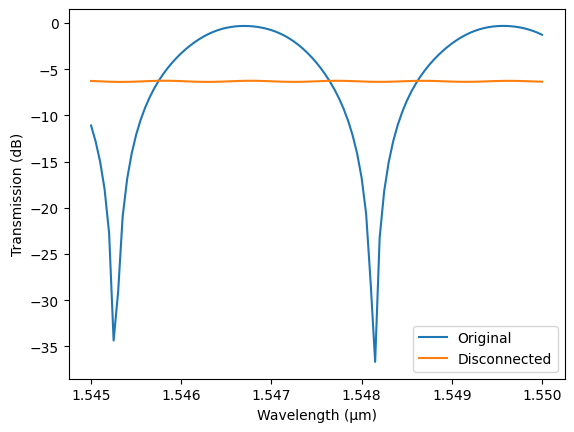

In [42]:
transmission3 = np.abs(s_matrix_new["P0@0", "P1@0"]) ** 2

_, ax = plt.subplots(1, 1)
ax.plot(wavelengths, 10 * np.log10(transmission), label="Original")
ax.plot(wavelengths, 10 * np.log10(transmission3), label="Disconnected")

ax.set(xlabel="Wavelength (µm)", ylabel="Transmission (dB)")
_ = ax.legend()

As expected, we see about 6 dB loss from the disconnected splitter.